# Kernel SVM

#### Dual Hard-Margin SVM

$$
\begin{align}
\min_{\alpha} \ \ & \frac{1}{2} \alpha^T Q_D \alpha - 1^T \alpha \\
\text{such that } & y^T \alpha = 0 \\
                  & \alpha_n \ge 0 \text{ for } n = 1, \cdots, N
\end{align}
$$

注意 $ Q_D $ 的計算仍是 $ O(\tilde{d}), q_{n,m} = y_n y_m z_n^T z_m $,  

需要先計算出 Q 才可能放入 QP solver 求解，此處仍是瓶頸。

如何找到較快的方法去計算 $ z_n^T z_m = \Phi(x_n)^T \Phi(x_m) $

### Fast Inner Product for $ \Phi_2 $

2<sup>nd</sup> order polynomial transform

$
\begin{align}
\Phi_2(x) & = \big( & 1,       &           &          & \\
          &         & x_1,     &  x_2,     &  \cdots, &  x_d \\
          &         & x_1^2  , &  x_1 x_2, &  \cdots, &  x_1 x_d \\
          &         & x_2 x_1, &  x_2^2  , &  \cdots, &  x_2 x_d \\
          &         & \vdots   &           &          & \\
          &         & x_d x_1, &  x_d x_2, &  \cdots, &  x_d^2 \\
          &         &\big)     &           &          & \\ 
\end{align}
$

$$
\begin{align}
\Phi_2(x)^T \Phi_2(x') & = 1 + \sum_{i=1}^d x_i x_i' + \sum_{i=1}^d \sum_{j=1}^d x_i x_j  x_i' x_j'  \\
& = 1 + \sum_{i=1}^d x_i x_i' + \sum_{i=1}^d x_i x_i' \ \ \sum_{j=1}^d x_j x_j' \\
& = 1 + x^T x' + \big( x^T x' \big) \big( x^T x' \big) 
\end{align}
$$

如此只要先算出 x, x' 的內積，然後做平方，$ O(d) $ 就可完成 原來的 $ O(d^2) $。

### Kernel : Transform + Inner Product

Kernel function 就是做 $ \Phi $ 空間轉換 再加上 進行內積 的兩個動作，結合起來一個步驟一起做，降低運算複雜度。

Kernel function: 

$$ K_{\Phi} \big( x, x' \big) \equiv \Phi \big( x \big)^T \cdot \Phi \big( x' \big) $$

$ \Phi_2 \iff K_{\Phi_2} \big( x, x' \big) = 1 + ( x^T x' ) + ( x^T x' )^2 $

Quadratic Coefficient $ q_{n,m} = y_n y_m z_n^T z_m = y_n y_m K \big( x_n, x_m \big) $

Optimal bias b: from $ SV(x_S, y_S) $

$ b = y_S - w^T z_S = y_S - \big( \sum_{SV} \alpha_n y_n z_n \big)^T z_S = y_S - \sum_{n=1}^N \alpha_n y_n \big( K( x_n, x_S ) \big) $

$ g_{SVM} \big( x \big) = sign \big( w^T \Phi(x) + b \big) = sign \Big( \sum_{n=1}^N \alpha_n y_n K (x_n, x) + b \Big) $

如此看來整個 SVM 算法都沒有需要轉換 $ x \to z $ 就可以只用 x 就獲得相同的結果。

- only SV needed to compute: $ w = \sum_{n=1}^N \alpha_n y_n z_n = \sum_{SV} \alpha_n y_n z_n $
- only SV needed to compute: $ b = y_n - w^T z_n \text{ with any SV } (z_n, y_n) $

#### Kernel Trick: plug in efficient kernel function to avoid dependence on $ \tilde{d} $

## Kernel Hard-Margin SVM Algorithm

STEP 1: $ q_{n,m} = y_n y_m K(x_n, x_m) $

STEP 2: $ p = \vec{-1}_N $ ; (A,c) for equal / bound constraints.

STEP 3: $ \alpha \leftarrow QP(Q_D, p, A, c) $

STEP 4: return SVs and their $ \alpha_n $ as well as b such that for new x,

$$ g_{SVM} (x) = sign \Big( \sum_{SV\ indices\ n} \alpha_n y_n K(x_n, x) + b \Big) $$

- STEP 1: time complexity $ O(N^2) $ and (kernel evaluation)
- STEP 2: QP with N variables and N+1 constraints.
- STEP 3+4: time complexity O(#SV) and (kernel evaluation)

#### Kernel SVM:

use computational shortcut to avoid $ \tilde{d} $ and predict with SV only.

## General Poly-2 Kernel

將原有的二次項轉換 $ \Phi $ 乘上個係數，可以獲得不同的變形。

$ \Phi_2 (x) = (1, x_1, \cdots, x_d, x_1^2, \cdots, x_d^2 ) $
$ \ \ \ \to \ \ \  K_{\Phi_2} (x, x') = 1 + x^T x' + (x^T x')^2 $

$ \Phi_2 (x) = (1, \sqrt{2} x_1, \cdots, \sqrt{2} x_d, x_1^2, \cdots, x_d^2 ) $
$ \ \ \ \to \ \ \  K_{\Phi_2} (x, x') = 1 + 2 x^T x' + (x^T x')^2 $

$ \Phi_2 (x) = (1, \sqrt{2 \gamma} x_1, \cdots, \sqrt{2 \gamma} x_d, \gamma x_1^2, \cdots, \gamma x_d^2 ) $
$ \ \ \ \to \ \ \  K_{\Phi_2} (x, x') = 1 + 2 \ \gamma \ x^T x' + \gamma^2 (x^T x')^2 $

### 比較常用的二次轉換形式:

$$ K_{2} (x, x') = \big( 1 + \gamma \ x^T x' \big)^2 \text{ with } \gamma \gt 0 $$

$ K_2 $ : 較 $ K_{\Phi_2} $ 更容易運算的形式

![img](imgs/c203-poly2-kernel-examples.png)

用了不同的 $ g_{SVM} $, 會找到不同的 SVs

change of KERNEL = change of margin definition.

> Need selecting K, just like selecting $ \Phi $

## General Polynomial Kernel

$$
K_2(x, x') = \big( \zeta + \gamma x^T x' \big)^2 \text{ with } \gamma > 0, \zeta \ge 0 \\
K_3(x, x') = \big( \zeta + \gamma x^T x' \big)^3 \text{ with } \gamma > 0, \zeta \ge 0 \\
\vdots \\
K_Q(x, x') = \big( \zeta + \gamma x^T x' \big)^Q \text{ with } \gamma > 0, \zeta \ge 0 
$$

embeds $ \Phi_Q $ specially with parameters $ \Big( \gamma, \zeta \Big) $

allows computing large-margin polynomial classification without dependence on $ \tilde{d} $

> SVM + Polynomial Kernel = Polynomial SVM

### Special Case: Linear Kernel : K1

$
K_1(x, x') = \big( 0 + 1 x^T x' \big)^1 \text{ with } \gamma > 0, \zeta \ge 0
$

### Example: Dual SVM with linear Kernel using CVXOPT

x:       [ 2. -8.] ,y:    1.0 : a=  [ 0.]
x:       [ 4.  5.] ,y:    1.0 : a= [ 0.349]
x:       [ 5. -6.] ,y:    1.0 : a=  [ 0.]
x:       [ 0.  0.] ,y:   -1.0 : a= [ 0.15]
x:       [ 1.  7.] ,y:   -1.0 : a=  [ 0.]
x:     [  3.  10.] ,y:   -1.0 : a= [ 0.198]


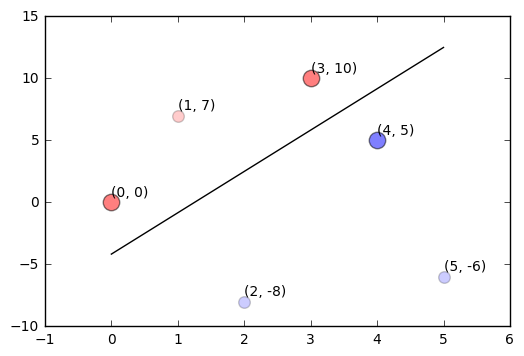

In [2]:
from cvxopt import matrix, solvers, printing
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=3,suppress=True)
COLORS  = {-1.0:'red', 1.0:'blue'}

# +1 points
x1 = np.array([[ 2,-8],[ 4, 5],[ 5,-6]]).astype(float)
# -1 points
x2 = np.array([[ 0, 0],[ 1, 7],[ 3, 10]]).astype(float)

y1 = np.repeat(1.0, len(x1))
y2 = np.repeat(-1.0, len(x2))

# join
x = np.concatenate((x1, x2), axis = 0)
y = np.concatenate((y1, y2), axis = 0)

# fit svm classifier

NUM = x.shape[0]
DIM = x.shape[1]

K = y[:, None] * x
K = np.dot(K, K.T)
P = matrix(K)
q = matrix(-np.ones((NUM, 1)))
G = matrix(-np.eye(NUM))
h = matrix(np.zeros(NUM))
A = matrix(y.reshape(1, -1))
b = matrix(np.zeros(1))
solvers.options['show_progress'] = False
sol = solvers.qp(P, q, G, h, A, b)
alphas = np.array(sol['x'])

# get weights
w = np.sum(alphas * y[:, None] * x, axis = 0)
# get bias
cond = (alphas > 1e-4).reshape(-1)
b = y[cond] - np.dot(x[cond], w)
bias = b[0]

norm = np.linalg.norm(w)
w, bias = w / norm, bias / norm

fig, ax = plt.subplots()
# draw separater
slope = -w[0] / w[1]
intercept = -bias / w[1]
px = np.arange(0, 6)
ax.plot(px, px * slope + intercept, 'k-')

# plot labels
for idx,d in enumerate(x):
    xi = d
    yi = y[idx]
    alphai = alphas[idx]
    print('x: %15s ,y: %6s : a= %6s' % (xi, yi, alphai))
    psize,ptran = (140,0.5) if alphai >= 0.001 else (70, 0.2)
    ax.scatter(xi[0], xi[1], c = COLORS[yi], s=psize, alpha=ptran)
    ax.text(xi[0], xi[1]+0.5, '(%d, %d)' % (xi[0], xi[1]))

plt.show()

上例大的點是找出來的 SVs, 使用 Linear Kernel

### Kernel of 2nd Polynomial Transform

1   - (  2, -8) - alphas: 0.000000
2   - (  0, -9) - alphas: 0.000000
3   - ( -5,-10) - alphas: 0.001246
4   - (  4, -5) - alphas: 0.004594
5   - (  0, 12) - alphas: 0.000000
6   - ( -5,  6) - alphas: 0.000000
7   - (  0, -4) - alphas: 0.000000
8   - (  1,  7) - alphas: 0.003613
9   - (  4,  6) - alphas: 0.000000
10  - (  3,  2) - alphas: 0.000000
11  - ( -3,  0) - alphas: 0.000000
12  - ( -5,  2) - alphas: 0.002226
w: 
[ 0.       0.01967 -0.06517  0.04537 -0.03262 -0.03262  0.05346]
b:  -2.7719, using alpha[2]:0.00125


/Users/larrysu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:110: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 2 but corresponding boolean dimension is 1


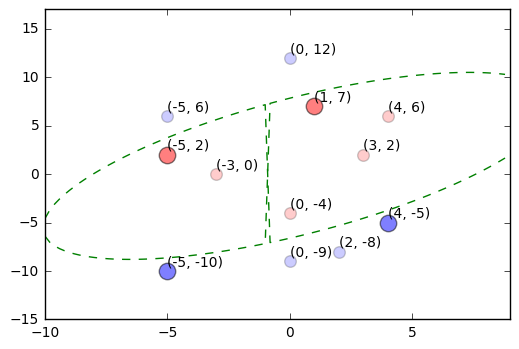

In [3]:
from cvxopt import matrix, solvers, printing
import numpy as np
import math
import matplotlib.pyplot as plt

np.set_printoptions(precision=5,suppress=True)
COLORS  = {-1.0:'red', 1.0:'blue'}

# sample data definitions
# +1 points
x1 = np.array([[ 2, -8],
               [ 0, -9],
               [-5,-10],
               [ 4, -5],
               [ 0, 12],
               [-5, 6]]).astype(float)
# -1 points
x2 = np.array([[ 0, -4],
               [ 1,  7],
               [ 4,  6],
               [ 3,  2],
               [-3,  0],
               [-5,  2]]).astype(float)

y1 = np.repeat(1.0, len(x1))
y2 = np.repeat(-1.0, len(x2))

x = np.concatenate((x1, x2), axis = 0)
y = np.concatenate((y1, y2), axis = 0)

NUM = x.shape[0]
DIM = x.shape[1]

K1 = x
K2 = np.dot(K1, K1.T)
K3 = 1 + K2 + np.power(K2, 2)

y = y.reshape(len(y),1)
Ky = y * y.T
K = K3 * Ky

P = matrix(K)
q = matrix(-np.ones((NUM, 1)))
G = matrix(-np.eye(NUM))
h = matrix(np.zeros(NUM))
A = matrix(y.reshape(1, -1))
b = matrix(np.zeros(1))
solvers.options['show_progress'] = False
sol = solvers.qp(P, q, G, h, A, b)
alphas = np.array(sol['x'])

[print('%-3d - (%3d,%3d) - alphas: %.6f' % (idx+1, x[idx][0], x[idx][1], ai)) for idx,ai in enumerate(alphas)]

def from_x_to_z(x):
    return np.array([1, x[0], x[1], np.power(x[0],2), x[0]*x[1], x[0]*x[1], np.power(x[1],2)])

z = []
for xi in x:
    z.append(from_x_to_z(xi))

z = np.array(z)

w = []

for ii in range(0,len(z[0])):
    wi = 0.0
    for ni,yi in enumerate(y):
        wi = wi + alphas[ni][0] * yi[0] * z[ni][ii]
    w.append(wi)

w = np.array(w)
print('w: \n%s' % w)

def y_in_z_space(w, z):
    return w.T * z

fig, ax = plt.subplots()

g_maxs = np.max(x,axis=0)
g_mins = np.min(x,axis=0)

ax.set_xlim([g_mins[0] - 5.0, g_maxs[0] + 5.0])
ax.set_ylim([g_mins[1] - 5.0, g_maxs[1] + 5.0])

# plot labels
for idx,d in enumerate(x):
    xi = d
    yi = y[idx]
    alphai = alphas[idx]
    psize,ptran = (140,0.5) if alphai >= 0.000001 else (70, 0.2)
    ax.scatter(xi[0], xi[1], c = COLORS[yi.item()], s=psize, alpha=ptran)
    ax.text(xi[0], xi[1]+0.5, '(%d, %d)' % (xi[0], xi[1]))

b = 0.0

for idx,ai in enumerate(alphas):
    if (ai > 0.000001):
        b = y[idx] - w.dot(z[idx])
        print('b: %8.4f, using alpha[%d]:%.5f' % (b, idx, ai))
        break

def get_x2_by_x1_w(w, x1):
    p = []
    p.append(w[6])
    p.append(w[2] + w[4]*x1 + w[5]*x1)
    p.append(w[0] + w[1]*x1 + w[3]*(x1*x1) + b)
    return np.roots(p)


svs = x[alphas > 0.00001]
alphas[alphas > 0.00001]

ln_x1s = []
ln_x2s_a = []
ln_x2s_b = []
for lx in np.arange(g_mins[0] - 5.0, g_maxs[0] + 5.0, 0.2):
    lx2s = get_x2_by_x1_w(w, lx)
    ln_x1s.append(lx)
    ln_x2s_a.append(lx2s[0])
    ln_x2s_b.append(lx2s[1])

plt.plot(ln_x1s, ln_x2s_a, '--g')
plt.plot(ln_x1s, ln_x2s_b, '--g')

plt.show()

### Kernel of infinite dimensional transform

無限維度的轉換 $ \Phi(x) $ ? Yes, 如果 K(x,x') 可以有效率的計算出。
